# Duó Deep Learning

This notebook will hold code for several deep learning and machine learning code.

## 1. Packages
Several packages need to be imported to provide code.
It may be usefull to import them in just one place.
Yo should run the cell below once each time you run the notebook.

In [128]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from dictFromCifar import loadData
from activationFunctions import sigmoid, relu, relu_backward, sigmoid_backward

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

## 2. Data

Let's use CIFAR-10 database.

### 2.1 Download:
You only need to download the data once for each notebook session.

In [129]:
origtrain_x, origtrain_y, origtest_x, origtest_y, classes = \
loadData("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
         "/media/duo/extra/python/tests/data/CIFAR-10/")


Data has apparently already been downloaded and unpacked.
All data (50,000 train images and label indexes, 10,000 test images and label indexes and 10 labels)
has been stored in appropriate arrays.


### 2.2 Let's do some checking on the data we have.

#### 2.2.1 First let's display some images to do a visual checking.

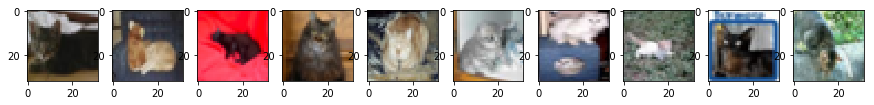

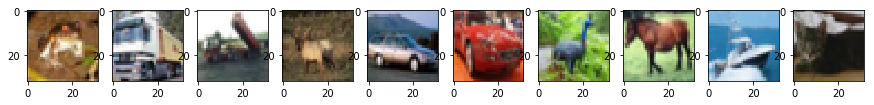

In [130]:
#show some cat images from dataset to visually check it

cats_train = origtrain_x[:,origtrain_y[0,:]==3]
ni = 10
for i in range(ni):
    plt.subplot(1, ni, i+1)
    image = cats_train[:,i]
    im = image.reshape(3,32,32).transpose(1,2,0)
    plt.imshow(np.uint8(im))
plt.show()

#show some images (any) from dataset to visually check it
ni = 10
for i in range(ni):
    plt.subplot(1, ni, i+1)
    image = origtrain_x[:,i]
    im = image.reshape(3,32,32).transpose(1,2,0)
    plt.imshow(np.uint8(im))
plt.show()

#### 2.2.2 Then let's reduce and format the data, and check some numbers.

In [131]:
#reduce examples and tests
train_x = origtrain_x[0:,0:1000]
train_y = origtrain_y[0:,0:1000]
test_x = origtest_x[0:,0:50]
test_y = origtest_y[0:,0:50]

# Standardize data to have feature values between 0 and 1
train_x = train_x/255
test_x = test_x/255

# Explore your dataset
m_train = train_x.shape[1]
num_px = train_x.shape[0]
m_test = test_x.shape[1]

print("Number of training examples: " + str(m_train))
print("Number of cats in training : " + str(train_x[:,train_y[0,:]==3].shape[1]))
print("Number of testing examples: " + str(m_test))
print("Number of cats in testing : " + str(test_x[:,test_y[0,:]==3].shape[1]))
print("train_x shape: " + str(train_x.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x shape: " + str(test_x.shape))# build and test a 2 layer neural network
### CONSTANTS DEFINING THE MODEL ####
n_x = 3072
# num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

print("test_y shape: " + str(test_y.shape))
print("classes: ", classes)


Number of training examples: 1000
Number of cats in training : 92
Number of testing examples: 50
Number of cats in testing : 3
train_x shape: (3072, 1000)
train_y shape: (1, 1000)
test_x shape: (3072, 50)
test_y shape: (1, 50)
classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. Trainning a 2-layer Neural Network

- The model's structure is: *LINEAR -> RELU -> LINEAR -> SIGMOID*. 
- Use random initialization for the weight matrices. Use `np.random.randn(shape)*0.01` with the correct shape.
- Use zero initialization for the biases. Use `np.zeros(shape)`.

In [132]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    Z = W.dot(A) + b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [133]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [134]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = - np.sum((Y.dot(np.log(AL.T + 1e-8))+((1-Y).dot(np.log((1 - AL.T) + 1e-8)))))/m
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [135]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = (dZ.dot(A_prev.T)/m) + 1e-8
    db = (np.sum(dZ, axis=1, keepdims=True)/m) + 1e-8
    dA_prev = W.T.dot(dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [136]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [137]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    ### END CODE HERE ###
        
    return parameters

In [138]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p


In [139]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(3)
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h, n_x) * 0.5
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.5
    b2 = np.zeros((n_y, 1))
    ### END CODE HERE ###
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    


In [140]:
# build 2 layer neural network


def two_layer_model(X, Y, layers_dims, learning_rate = 0.00000055, num_iterations = 3000, print_cost=False):
  """
  Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
  Arguments:
  X -- input data, of shape (n_x, number of examples)
  Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
  layers_dims -- dimensions of the layers (n_x, n_h, n_y)
  num_iterations -- number of iterations of the optimization loop
  learning_rate -- learning rate of the gradient descent update rule
  print_cost -- If set to True, this will print the cost every 100 iterations
  Returns:
  parameters -- a dictionary containing W1, W2, b1, and b2
  """
  np.random.seed(1)
  grads = {}
  costs = []
  # to keep track of the cost
  m = X.shape[1]
  (n_x, n_h, n_y) = layers_dims
  # number of examples
  # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
  ### START CODE HERE ### (≈ 1 line of code)
  parameters = initialize_parameters(n_x, n_h, n_y)
  ### END CODE HERE ###
  # Get W1, b1, W2 and b2 from the dictionary parameters.
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  # Loop (gradient descent)
  for i in range(0, num_iterations):
    # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
    A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
    ### END CODE HERE ###
    # Compute cost
    ### START CODE HERE ### (≈ 1 line of code)
    cost = compute_cost(A2, Y)
    ### END CODE HERE ###
    # Initializing backward propagation
    dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
    # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
    ### START CODE HERE ### (≈ 2 lines of code)
    dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
    dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
    ### END CODE HERE ###
    # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
    grads['dW1'] = dW1
    grads['db1'] = db1
    grads['dW2'] = dW2
    grads['db2'] = db2
    # Update parameters.
    ### START CODE HERE ### (approx. 1 line of code)
    parameters = update_parameters(parameters, grads, learning_rate)
    ### END CODE HERE ###
    # Retrieve W1, b1, W2, b2 from parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    # Print the cost every 100 training example
    if print_cost and i % 100 == 0:
      print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    if print_cost and i % 100 == 0:
      costs.append(cost)

  # plot the cost
  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per tens)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()
  
  return parameters

Cost after iteration 0: 29.448175270570143
Cost after iteration 100: 28.828392532840006
Cost after iteration 200: 28.21346158365171
Cost after iteration 300: 27.603460742288792
Cost after iteration 400: 26.997825973606485
Cost after iteration 500: 26.39667674254586
Cost after iteration 600: 25.800287572539343
Cost after iteration 700: 25.208078365062043
Cost after iteration 800: 24.620083573554457
Cost after iteration 900: 24.036917925684307
Cost after iteration 1000: 23.458389198478265
Cost after iteration 1100: 22.884097694714388
Cost after iteration 1200: 22.313652966321726
Cost after iteration 1300: 21.747072099720345
Cost after iteration 1400: 21.18465725199453
Cost after iteration 1500: 20.626261482110046
Cost after iteration 1600: 20.071582897692846
Cost after iteration 1700: 19.520714528552947
Cost after iteration 1800: 18.973737799585468
Cost after iteration 1900: 18.430322620566194
Cost after iteration 2000: 17.890622399493505
Cost after iteration 2100: 17.354904798511537
Cos

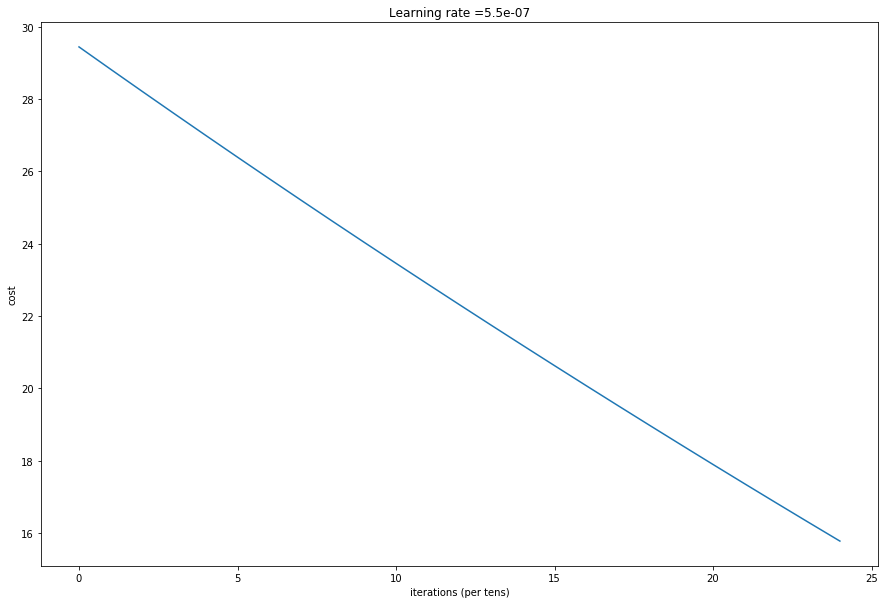

In [141]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 3072
# num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

#parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
parameters = two_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost=True)

In [142]:
pred_train = predict(train_x, train_y, parameters)

NameError: name 'L_model_forward' is not defined

In [ ]:
pred_test = predict(test_x, test_y, parameters)